# Импорт библиотек

In [ ]:
# ДОСТУП К ФАЙЛАМ НА ДИСКЕ
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# РАБОТА С ТАБЛИЦАМИ
!pip install openpyxl

In [ ]:
# ОБРАБОТКА ТЕКСТОВ
!pip install pymorphy3

In [ ]:
# РАБОТА С ТАБЛИЦАМИ ДАННЫХ
import pandas as pd
import json
import numpy as np

from collections import Counter

# предобработка текстовых данных
import re
import nltk
from nltk.tokenize import RegexpTokenizer
nltk.download('stopwords')
from nltk.corpus import stopwords
sw = stopwords.words('russian')
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
snowball = SnowballStemmer('russian')

from pymorphy3 import MorphAnalyzer
morph = MorphAnalyzer()
from string import punctuation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Предобработка датасета

1. Убрать лишние столбцы.

2. Убрать строки с Nan.

3. Работа с повторяющимися ответами: во-первых, найти дубликаты, которые классифицированы в разные категории или в разные баллы по оригинальности, то есть ошибочные примеры; во-вторых, "схлопнуть" повторяющиеся ответы разных участников.

4. Убрать все лишние категории типа 0, 5555.

5. *Сделать датасет без стопслов с лемматизацией (уникальные ответы)

6. *Сделать датасет со стеммингом (уникальные ответы)

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/Гилфорд Маг Диплом Розовская/New results/raw data Guilford.xlsx')
data.shape

(12920, 11)

In [ ]:
data.head(5)

,Unnamed: 0,ID,attempt,n,answer,category,origNew,особенности,groupInc,project,year
0,NaN,PTxGzRMvLY,1,1.0,сложить из спичек домик,05.01.01.,3.0,с фиксациями,1,анаграммы с фиксациями,2021
1,NaN,PTxGzRMvLY,1,2.0,использовать спички как опору чего - нибудь,06.04.20.,5.0,с фиксациями,1,анаграммы с фиксациями,2021
2,NaN,PTxGzRMvLY,1,3.0,спичками мжно ковыряться в зубах,06.01.00.,3.0,с фиксациями,1,анаграммы с фиксациями,2021
3,NaN,PTxGzRMvLY,1,4.0,"если сложить спички в виде колодца, можно испо...",06.07.05.,5.0,с фиксациями,1,анаграммы с фиксациями,2021
4,NaN,PTxGzRMvLY,1,5.0,"если разукрасить спички, то можно сложить их н...",05.01.00.,2.0,с фиксациями,1,анаграммы с фиксациями,2021


## 1. убираем лишние столбцы:

In [ ]:
data = data.drop(['Unnamed: 0', 'особенности','groupInc', 'project', 'year'], axis=1)
data.head(5)

,ID,attempt,n,answer,category,origNew
0,PTxGzRMvLY,1,1.0,сложить из спичек домик,05.01.01.,3.0
1,PTxGzRMvLY,1,2.0,использовать спички как опору чего - нибудь,06.04.20.,5.0
2,PTxGzRMvLY,1,3.0,спичками мжно ковыряться в зубах,06.01.00.,3.0
3,PTxGzRMvLY,1,4.0,"если сложить спички в виде колодца, можно испо...",06.07.05.,5.0
4,PTxGzRMvLY,1,5.0,"если разукрасить спички, то можно сложить их н...",05.01.00.,2.0


## 2. убираем строки с Nan:

In [ ]:
data = data.dropna()
data.shape

(9267, 6)

## 3. убираем дубликаты:

до того как приступить, приведём все тексты к нижнему регистру, очистим от пунктуации и чисел:

In [ ]:
def tokenizer(text):
    # ТОКЕНИЗАЦИЯ
    pattern = '[а-яa-z]+'
    tokens = re.findall(pattern, text.lower())

    return ' '.join(tokens)

In [ ]:
%%time
prepr_texts = [tokenizer(text) for text in data['answer']]
data['prepr_text'] = prepr_texts

CPU times: user 50.2 ms, sys: 0 ns, total: 50.2 ms
Wall time: 56.4 ms


<timed exec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


сначала уберём "полные" дубликаты (по столбцам ID, attempt & answer) - если значения в этих 3х столбцах повторились, значит, один ответ участника в рамках одной попытки учли дважды

In [ ]:
data= data.drop_duplicates(subset=['ID', 'attempt', 'prepr_text'])
data.shape

(9261, 7)

теперь ищем дубликаты, которые классифицированы в разные категории или в разные баллы по оригинальности, то есть ошибочные примеры. Для этого сначала выделим все ответы, которые дублируются, в том числе у разных пользователей (их потом нужно будет "схлопнуть", но сначала из них нужно убрать ошибочно размеченные примеры, чтобы такие  наверняка не остались в датасете).
Для каждого повторяющегося ответа определим самые частые значения категории и оригинальности (дефолтные). Потом отсортируем те строки, в которых category или origNew не совпадают с дефолтным значением:

(P.S. даже если ответов, размеченных по-разному, поровну, они всё равно отсортируются по этому принципу)

In [ ]:
dupl_answers = data[data.duplicated(['prepr_text'], keep=False)]
unique_answers = dupl_answers['prepr_text'].unique()

all_false_rows = pd.DataFrame()

for unq_ans in unique_answers:
    same_answer_rows = dupl_answers.loc[dupl_answers['prepr_text'] == unq_ans]

    # самые частые категория и оригинальность этого ответа (или одно из 2х значений)
    r_category = same_answer_rows['category'].value_counts().idxmax()
    r_origNew = same_answer_rows['origNew'].value_counts().idxmax()

# сортируем ошибочные ответы
    false_rows = same_answer_rows.loc[(same_answer_rows['category'] != r_category) |
                                     (same_answer_rows['origNew'] != r_origNew)]

    if not false_rows.empty:
      all_false_rows = pd.concat([all_false_rows, false_rows])

    else:
        continue

# merging and dropping common rows
data = pd.merge(data, all_false_rows, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
data.shape

(9138, 7)

теперь убираем все повторяющиеся ответы, оставляем только уникальные варианты:

In [ ]:
data= data.drop_duplicates(subset=['prepr_text'])
data.shape

(7436, 7)

на всякий случай эксплицитно присвоим столбцам правильные типы данных:

In [ ]:
data = data.astype({'ID': str, 'attempt': int,'n': int, 'answer': str, 'category': str, 'origNew': int, 'prepr_text': str})

## 4. делаем все лишние категории типа 0, 5555:

In [ ]:
data.loc[data['category'] == '0']

,ID,attempt,n,answer,category,origNew,prepr_text


In [ ]:
data.loc[data['category'] == '5555']

,ID,attempt,n,answer,category,origNew,prepr_text
53,Vrwss9y6yj,1,4,сделать запас на случай войны,5555,6,сделать запас на случай войны
131,4GRNFx8xEJ,1,2,"воткнуть в цветочные горшки, чтобы кошка не за...",5555,6,воткнуть в цветочные горшки чтобы кошка не зал...
159,WKnks2pPXH,1,3,Поле для игры в крестики - нолики а также сами...,5555,6,поле для игры в крестики нолики а также сами к...
236,J7CZmNgW3x,2,2,рычаг - как рычаг для подъема тяжестей,5555,6,рычаг как рычаг для подъема тяжестей
241,wusqksM8bJ,2,1,"снять ролик, фильм, ""спичечный челлендж"" в тик...",5555,6,снять ролик фильм спичечный челлендж в тик ток
...,...,...,...,...,...,...,...
4415,333,1,3,Приклеить к спичкам маленькие магниты и отмеча...,5555,6,приклеить к спичкам маленькие магниты и отмеча...
7123,s.012d3d3a-aa00-41e8-8b0f-dba82337cf46.txt,2,4,засунуть в нос и изображать моржа,5555,6,засунуть в нос и изображать моржа
8331,s.e6a0605d-8ce3-4346-bc6e-da644c117a54.txt,2,3,"способ научить широко улыбаться, зажимая в зуб...",5555,6,способ научить широко улыбаться зажимая в зуба...
8515,2008_2009_4,0,6,поджечь в классе на уроке ради прикола,5555,6,поджечь в классе на уроке ради прикола


In [ ]:
data = data.drop(data[(data.category == '5555') | (data.category == '0')].index)
data.shape

(7356, 7)

In [ ]:
def simplify_cat(full_cat):
    result = re.search('([0-9]{2})\.', full_cat)
    return int(result.group(1))

In [ ]:
simple_categories = [simplify_cat(str(value)) for value in data['category']]
data['simple_category'] = simple_categories

data = data.drop(['category'], axis=1)

Результат:

In [ ]:
data

,ID,attempt,n,answer,origNew,prepr_text,simple_category
0,PTxGzRMvLY,1,1,сложить из спичек домик,3,сложить из спичек домик,5
1,PTxGzRMvLY,1,2,использовать спички как опору чего - нибудь,5,использовать спички как опору чего нибудь,6
2,PTxGzRMvLY,1,3,спичками мжно ковыряться в зубах,3,спичками мжно ковыряться в зубах,6
3,PTxGzRMvLY,1,4,"если сложить спички в виде колодца, можно испо...",5,если сложить спички в виде колодца можно испол...,6
4,PTxGzRMvLY,1,5,"если разукрасить спички, то можно сложить их н...",2,если разукрасить спички то можно сложить их на...,5
...,...,...,...,...,...,...,...
9256,2008_2009_320,0,2,для поджога мусора,4,для поджога мусора,1
9257,2008_2009_320,0,3,для играния,3,для играния,7
9258,2008_2009_321,0,1,зубочистка - зубы чистить,3,зубочистка зубы чистить,6
9259,2008_2009_321,0,2,как палочка - для игр,3,как палочка для игр,7


In [ ]:
data.to_excel(f'/content/drive/MyDrive/Гилфорд Маг Диплом Розовская/New results/cleaned data Guilford.xlsx')

*На всякий случай в готовом файле проверяем повторы в столбцах E (answers) и G (prepr_text). Получаем заветное:*

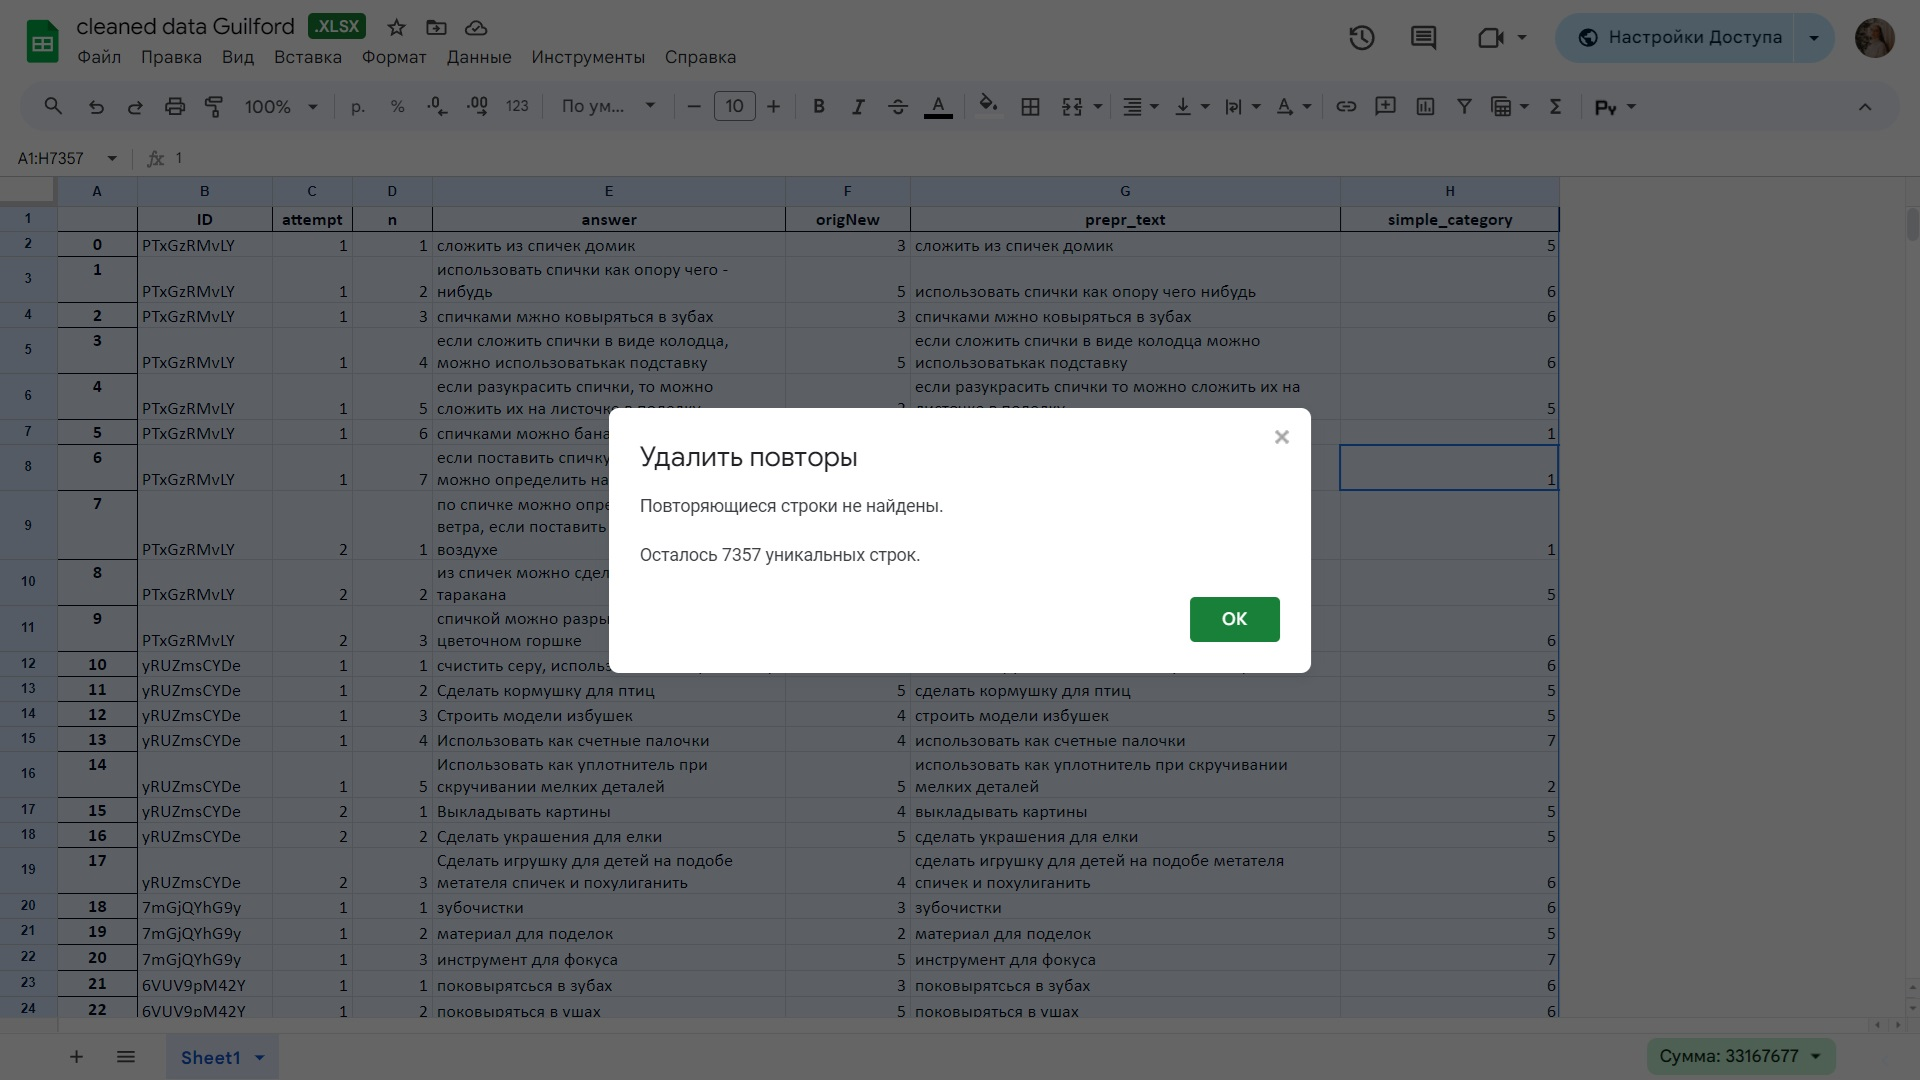

## 5. *делаем датасет без стопслов с лемматизацией (уникальные ответы):

In [ ]:
def lemmatize(text):

  tokens = text.split()

  # ЛЕММАТИЗАЦИЯ
  lemmas = []
  for token in tokens:
    result = morph.parse(token)
    lemmas.append(result[0].normal_form)

  # ИСКЛЮЧЕНИЕ СТОП-СЛОВ
  no_sw_list = [w for w in lemmas if w not in sw]

  return ' '.join(no_sw_list)

In [ ]:
%%time
lemm_texts = [lemmatize(text) for text in data['prepr_text']]
data['lemm_text'] = lemm_texts

CPU times: user 8.54 s, sys: 28.4 ms, total: 8.56 s
Wall time: 8.72 s


In [ ]:
data['lemm_text'].replace('', np.nan, inplace=True)
data = data.dropna()

In [ ]:
data= data.drop_duplicates(subset=['lemm_text'])
data = data.drop(['prepr_text'], axis=1)
data

,ID,attempt,n,answer,origNew,simple_category,lemm_text
0,PTxGzRMvLY,1,1,сложить из спичек домик,3,5,сложить спичка домик
1,PTxGzRMvLY,1,2,использовать спички как опору чего - нибудь,5,6,использовать спичка опора нибыть
2,PTxGzRMvLY,1,3,спичками мжно ковыряться в зубах,3,6,спичка мжный ковыряться зуб
3,PTxGzRMvLY,1,4,"если сложить спички в виде колодца, можно испо...",5,6,сложить спичка вид колодец использоватькак под...
4,PTxGzRMvLY,1,5,"если разукрасить спички, то можно сложить их н...",2,5,разукрасить спичка сложить листочек поделка
...,...,...,...,...,...,...,...
9256,2008_2009_320,0,2,для поджога мусора,4,1,поджог мусор
9257,2008_2009_320,0,3,для играния,3,7,играния
9258,2008_2009_321,0,1,зубочистка - зубы чистить,3,6,зубочистка зуб чистить
9259,2008_2009_321,0,2,как палочка - для игр,3,7,палочка игра


In [ ]:
data = data.astype({'ID': str, 'attempt': int,'n': int, 'answer': str, 'simple_category': str, 'origNew': int, 'lemm_text': str})

In [ ]:
data.to_excel(f'/content/drive/MyDrive/Гилфорд Маг Диплом Розовская/New results/lemms cleaned data Guilford.xlsx')

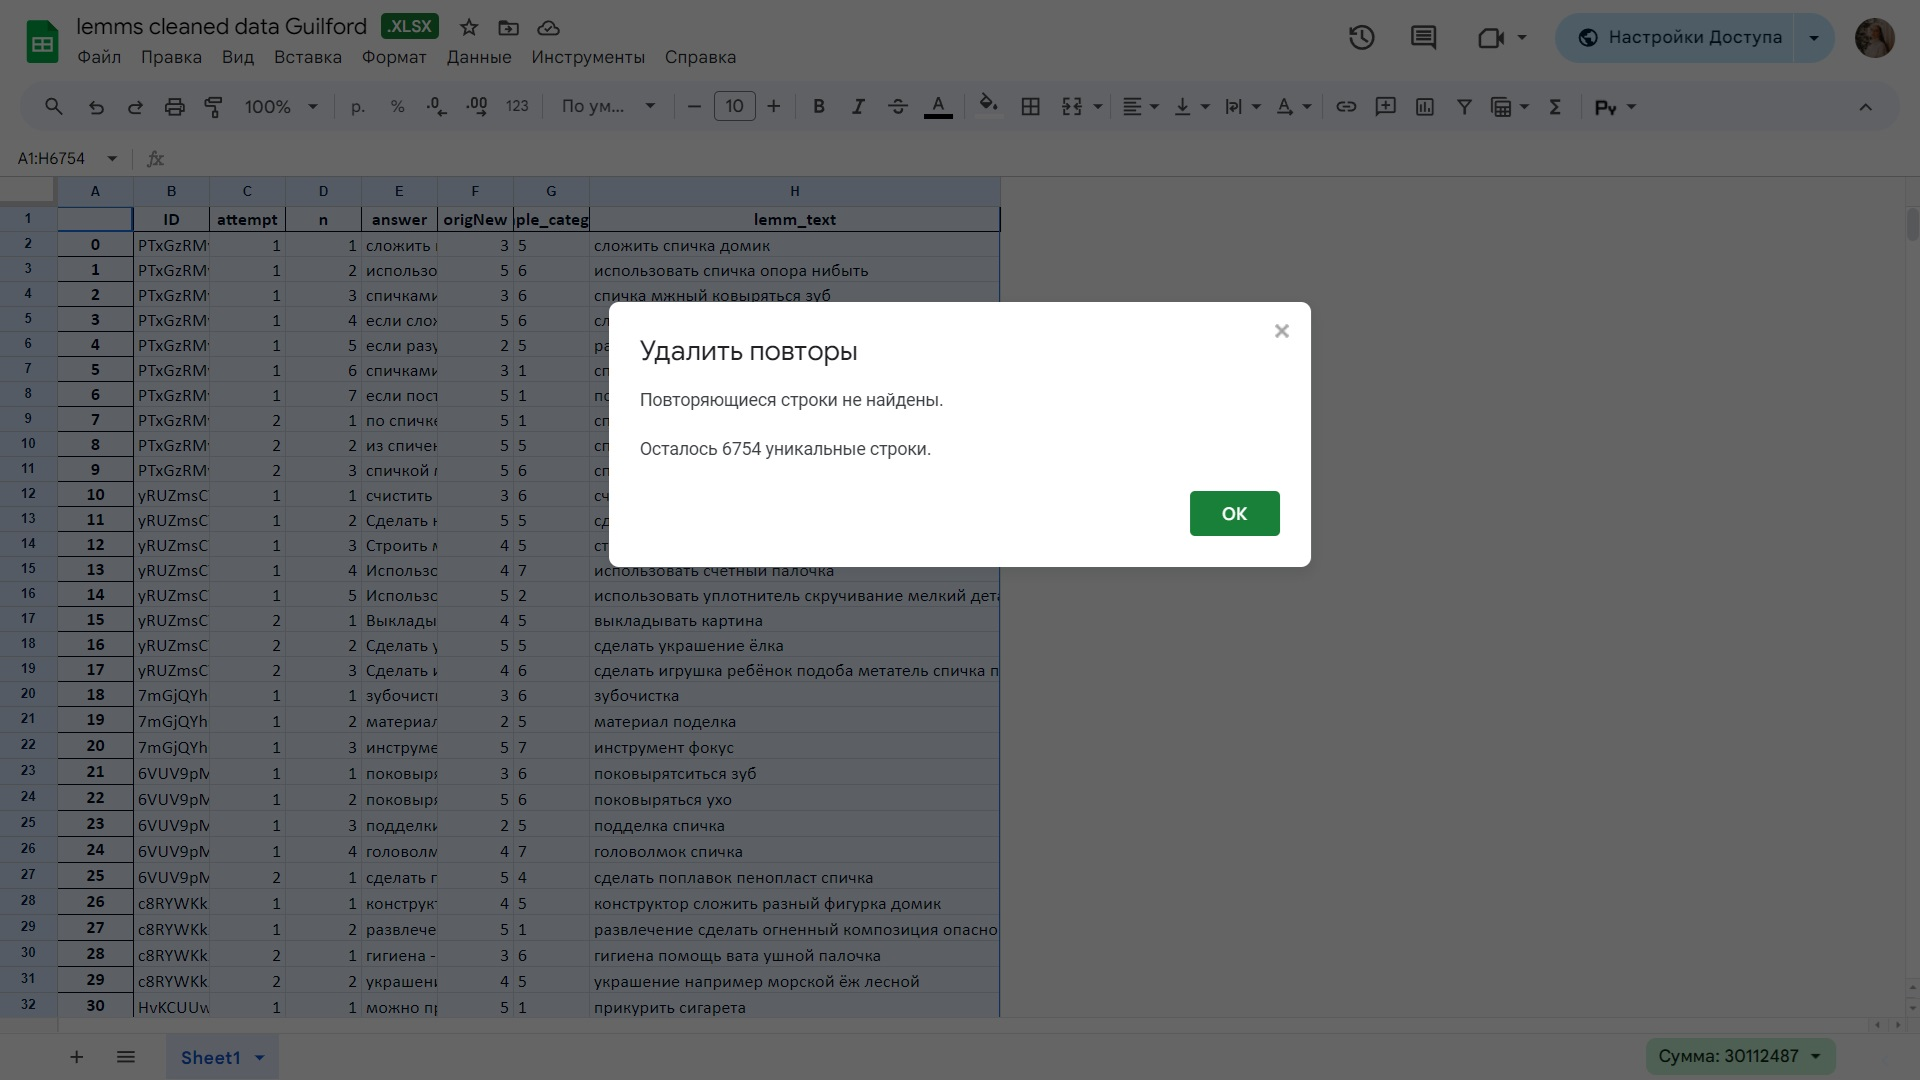

## 6. *делаем датасет со стэммингом (уникальные ответы):

In [ ]:
def stemming(text):
  no_sw_list = text.split()

  # СТЭММИНГ
  result = [snowball.stem(w) for w in no_sw_list]

  return ' '.join(result)

In [ ]:
%%time
stemm_texts = [stemming(text) for text in data['lemm_text']]
data['stemm_text'] = stemm_texts

CPU times: user 2.49 s, sys: 12.6 ms, total: 2.5 s
Wall time: 3.61 s


In [ ]:
data['stemm_text'].replace('', np.nan, inplace=True)
data = data.dropna()

In [ ]:
data= data.drop_duplicates(subset=['stemm_text'])
data = data.drop(['lemm_text'], axis=1)
data

,ID,attempt,n,answer,origNew,simple_category,stemm_text
0,PTxGzRMvLY,1,1,сложить из спичек домик,3,5,слож спичк домик
1,PTxGzRMvLY,1,2,использовать спички как опору чего - нибудь,5,6,использова спичк опор ниб
2,PTxGzRMvLY,1,3,спичками мжно ковыряться в зубах,3,6,спичк мжны ковыря зуб
3,PTxGzRMvLY,1,4,"если сложить спички в виде колодца, можно испо...",5,6,слож спичк вид колодец использоватькак подставк
4,PTxGzRMvLY,1,5,"если разукрасить спички, то можно сложить их н...",2,5,разукрас спичк слож листочек поделк
...,...,...,...,...,...,...,...
9256,2008_2009_320,0,2,для поджога мусора,4,1,поджог мусор
9257,2008_2009_320,0,3,для играния,3,7,игран
9258,2008_2009_321,0,1,зубочистка - зубы чистить,3,6,зубочистк зуб чист
9259,2008_2009_321,0,2,как палочка - для игр,3,7,палочк игр


In [ ]:
data = data.astype({'ID': str, 'attempt': int,'n': int, 'answer': str, 'simple_category': str, 'origNew': int, 'stemm_text': str})

In [ ]:
data.to_excel(f'/content/drive/MyDrive/Гилфорд Маг Диплом Розовская/New results/stemms cleaned data Guilford.xlsx')

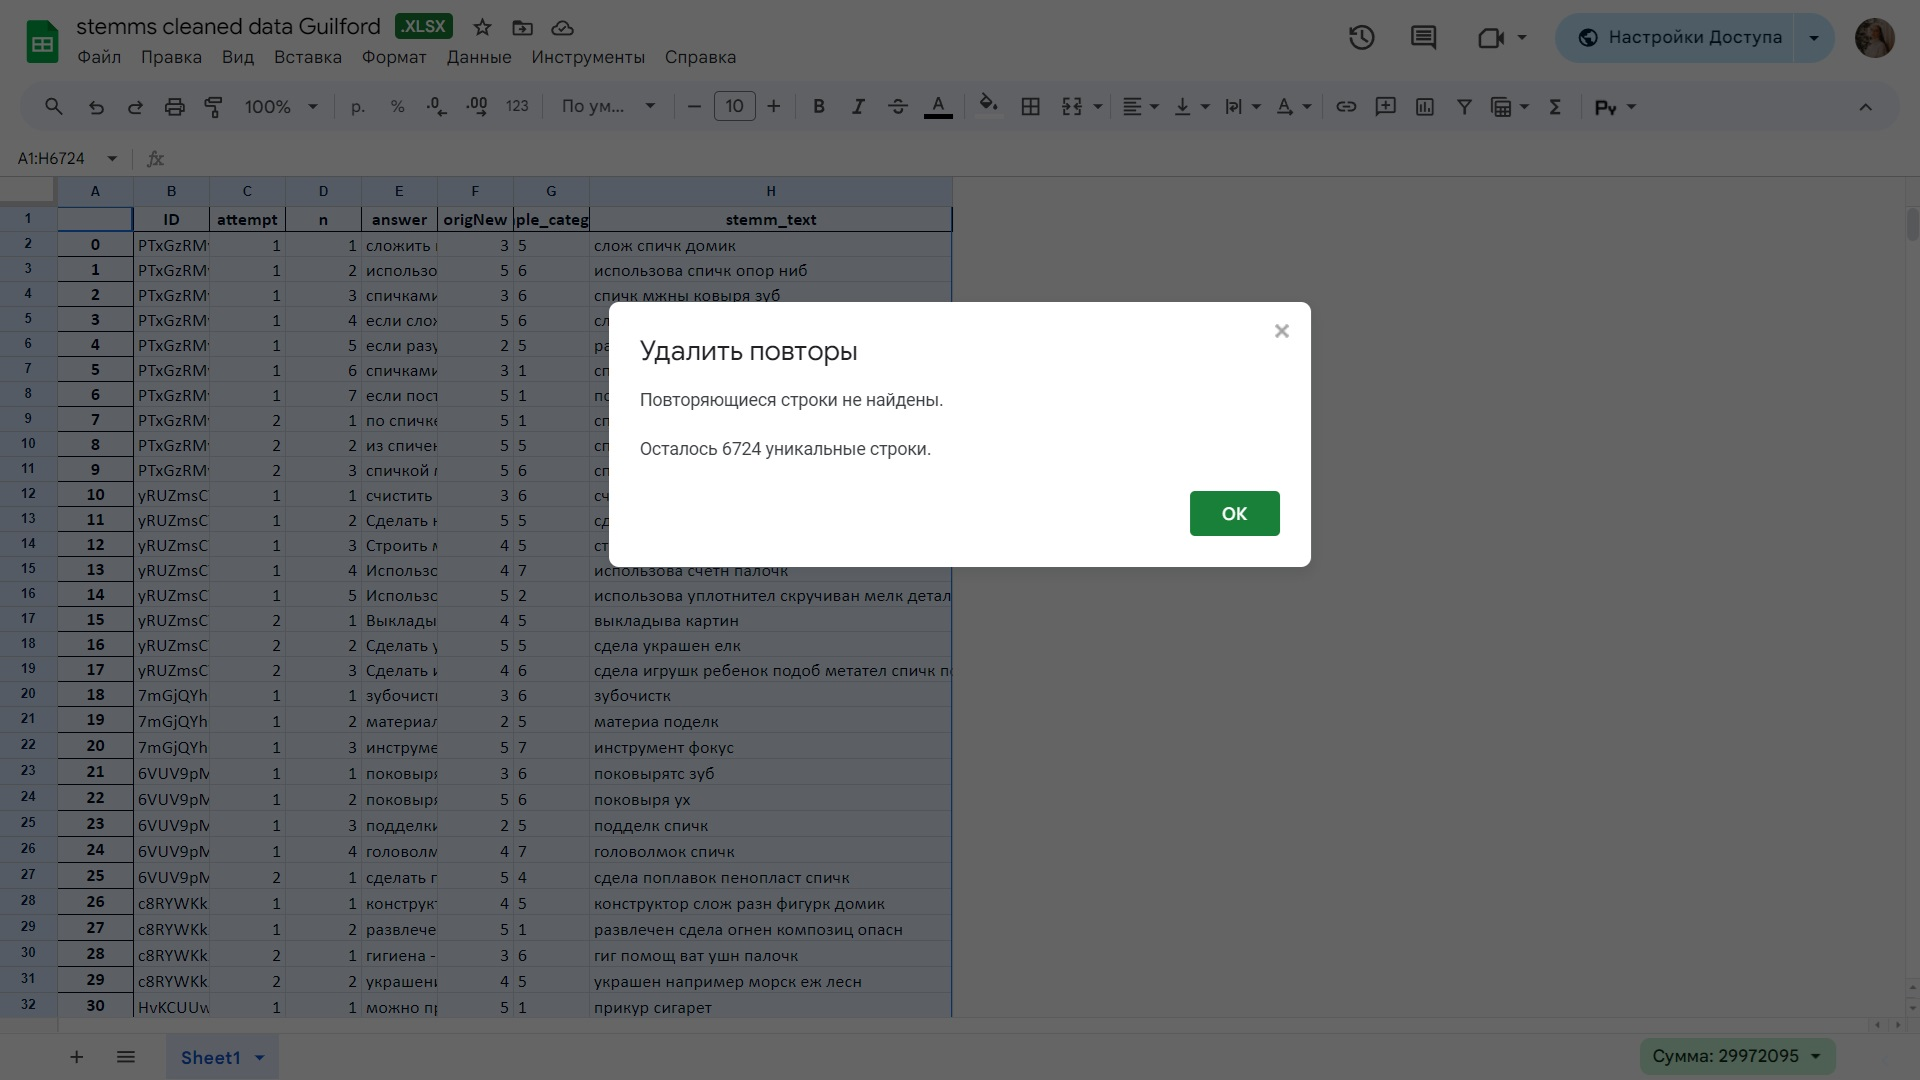